# Trefoil framework PoC on NSL-KDD



## Environment preparation

In [2]:
# Mount your Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import warnings
from google.colab import files

# Suppress all warning messages
warnings.filterwarnings("ignore")

# Check if the Kaggle API credentials file already exists
kaggle_credentials_path = os.path.expanduser("~/.kaggle/kaggle.json")

if not os.path.exists(kaggle_credentials_path):

    if not os.path.exists(os.path.join("/content/drive/MyDrive/.kaggle/", "kaggle.json")):

      # Upload your Kaggle API credentials file (kaggle.json)
      files.upload()

      !mv kaggle.json "/content/drive/MyDrive/.kaggle/"
      !chmod 600 "/content/drive/MyDrive/.kaggle/kaggle.json"

    # Move the Kaggle API Credentials File
    !mkdir -p ~/.kaggle
    !cp '/content/drive/MyDrive/.kaggle/kaggle.json' ~/.kaggle/

else:

    print("Kaggle API credentials file already exists.")

In [4]:
import os
from psutil import virtual_memory
from tabulate import tabulate

# Function to get CPU information
def get_cpu_info():
    cpu_info = os.popen('lscpu').read()
    return cpu_info

# Function to get RAM information
def get_ram_info():
    ram = virtual_memory()
    total_ram = f"{ram.total / 1e9:.2f} GB"
    available_ram = f"{ram.available / 1e9:.2f} GB"
    return total_ram, available_ram

# Function to get GPU information
def get_gpu_info():
    # Execute nvidia-smi and get its output
    gpu_info = os.popen('nvidia-smi --query-gpu=name,memory.total,memory.used,memory.free --format=csv,noheader,nounits').read().strip()

    # Split the output to get individual GPU details
    details = gpu_info.split(", ")

    # Return GPU name, total, used, and free memory
    return details[0], f"{details[1]} MB", f"{details[2]} MB", f"{details[3]} MB"

# Collect system information
cpu_info = get_cpu_info()
total_ram, available_ram = get_ram_info()
try:
  gpu_name, gpu_total_memory, gpu_used_memory, gpu_free_memory = get_gpu_info()
except:
  gpu_name, gpu_total_memory, gpu_used_memory, gpu_free_memory = 'N/a', 'N/a', 'N/a', 'N/a'

# Extract relevant CPU information
cpu_type = ""
cpu_architecture = ""

for line in cpu_info.splitlines():
    if "Model name:" in line:
        cpu_type = line.split(":")[1].strip()
    elif "Architecture:" in line:
        cpu_architecture = line.split(":")[1].strip()

# Create a table
table = [
    ["CPU Type", cpu_type],
    ["CPU Architecture", cpu_architecture],
    ["Total RAM", total_ram],
    ["Available RAM", available_ram],
    ["GPU Name", gpu_name],
    ["GPU Total Memory", gpu_total_memory],
    ["GPU Used Memory", gpu_used_memory],
    ["GPU Free Memory", gpu_free_memory]
]

# Display the table
print(tabulate(table, headers=["Characteristic", "Value"], tablefmt="pretty"))


+------------------+--------------------------------+
|  Characteristic  |             Value              |
+------------------+--------------------------------+
|     CPU Type     | Intel(R) Xeon(R) CPU @ 2.20GHz |
| CPU Architecture |             x86_64             |
|    Total RAM     |            54.76 GB            |
|  Available RAM   |            53.18 GB            |
|     GPU Name     |              N/a               |
| GPU Total Memory |              N/a               |
| GPU Used Memory  |              N/a               |
| GPU Free Memory  |              N/a               |
+------------------+--------------------------------+


In [5]:
# For reproducibility
from numpy.random import seed
seed_value= 1
os.environ['PYTHONHASHSEED']=str(seed_value)
seed(seed_value)

TASK_NAME = "FHE test with NSL-KDD"
run_with_gpu = False

In [6]:
import os
import pandas as pd

# Specify the dataset name
dataset_name = "hassan06/nslkdd"

# Specify the destination folder in your Google Drive
destination_folder = "/content/drive/MyDrive/NSL-KDD-BM"

# Check if the dataset file already exists in your Google Drive
dataset_file_path = os.path.join(destination_folder, "nslkdd.zip")

if not os.path.exists(dataset_file_path):

  # Download the dataset and save it to your Google Drive
  !kaggle datasets download -d $dataset_name -p $destination_folder

  # Unzip the downloaded dataset
  import zipfile
  with zipfile.ZipFile(f"{destination_folder}/nslkdd.zip", "r") as zip_ref:
      zip_ref.extractall(destination_folder)

  print("Download complete.")

else:
  print("Dataset already exists. Skipping download.")

# Remove the downloaded zip file (optional)
#!rm -f {destination_folder}/nslkdd.zip

Dataset already exists. Skipping download.


In [7]:
!ls -ahl '/content/drive/MyDrive/NSL-KDD-BM'

total 148M
-rw------- 1 root root  33K Oct 10 14:27 index.html
-rw------- 1 root root 8.5K Oct 10 14:27 KDDTest1.jpg
-rw------- 1 root root 1.7M Oct 10 14:27 KDDTest-21.arff
-rw------- 1 root root 1.8M Oct 10 14:27 KDDTest-21.txt
-rw------- 1 root root 3.3M Oct 10 14:27 KDDTest+.arff
-rw------- 1 root root 3.3M Oct 10 14:27 KDDTest+.txt
-rw------- 1 root root 8.4K Oct 10 14:27 KDDTrain1.jpg
-rw------- 1 root root 3.6M Oct 10 14:27 KDDTrain+_20Percent.arff
-rw------- 1 root root 3.7M Oct 10 14:27 KDDTrain+_20Percent.txt
-rw------- 1 root root  18M Oct 10 14:27 KDDTrain+.arff
-rw------- 1 root root  19M Oct 10 14:27 KDDTrain+.txt
drwx------ 2 root root 4.0K Oct 10 14:27 nsl-kdd
-rw------- 1 root root  32M Oct 10 14:28 nsl_kdd.csv
-rw------- 1 root root  50M Oct 10 14:28 nsl_kdd_encoded.csv
-rw------- 1 root root  924 Oct 10 14:29 nsl_kdd_results.pkl
-rw------- 1 root root  14M Oct 22  2019 nslkdd.zip


In [14]:
# Check if nsl-kdd processed dataframe is in location
nsl_df_file_path = os.path.join(destination_folder, "nsl_kdd.csv")
if os.path.exists(nsl_df_file_path):
  nsl_df = pd.read_csv(nsl_df_file_path)
else:
  nsl_df = pd.read_csv('/content/drive/MyDrive/NSL-KDD-BM/KDDTrain+.txt')

  # add the column labels
  columns = (['duration'
  ,'protocol_type'
  ,'service'
  ,'flag'
  ,'src_bytes'
  ,'dst_bytes'
  ,'land'
  ,'wrong_fragment'
  ,'urgent'
  ,'hot'
  ,'num_failed_logins'
  ,'logged_in'
  ,'num_compromised'
  ,'root_shell'
  ,'su_attempted'
  ,'num_root'
  ,'num_file_creations'
  ,'num_shells'
  ,'num_access_files'
  ,'num_outbound_cmds'
  ,'is_host_login'
  ,'is_guest_login'
  ,'count'
  ,'srv_count'
  ,'serror_rate'
  ,'srv_serror_rate'
  ,'rerror_rate'
  ,'srv_rerror_rate'
  ,'same_srv_rate'
  ,'diff_srv_rate'
  ,'srv_diff_host_rate'
  ,'dst_host_count'
  ,'dst_host_srv_count'
  ,'dst_host_same_srv_rate'
  ,'dst_host_diff_srv_rate'
  ,'dst_host_same_src_port_rate'
  ,'dst_host_srv_diff_host_rate'
  ,'dst_host_serror_rate'
  ,'dst_host_srv_serror_rate'
  ,'dst_host_rerror_rate'
  ,'dst_host_srv_rerror_rate'
  ,'Label'
  ,'level'])

  nsl_df.columns = columns

# Now, 'nsl_df' contains NSL-KDD data in a Pandas DataFrame
nsl_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Label,level
0,0.000000,udp,other,SF,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,0.714286
1,0.000000,tcp,private,S0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,0.904762
2,0.000000,tcp,http,SF,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,1.000000
3,0.000000,tcp,http,SF,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,1.000000
4,0.000000,tcp,private,REJ,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125967,0.000000,tcp,private,S0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,...,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,0.952381
125968,0.000186,udp,private,SF,7.608895e-08,1.106923e-07,0.0,0.0,0.0,0.0,...,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal,1.000000
125969,0.000000,tcp,smtp,SF,1.616709e-06,2.931438e-07,0.0,0.0,0.0,0.0,...,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal,0.857143
125970,0.000000,tcp,klogin,S0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,...,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,0.952381


## Data preprocessing

In [15]:
# Identify categorical columns (non-numeric)
categorical_columns = nsl_df.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('Label')

# Encode the Label with 0 value for normal and 1 for the rest of the attacks
nsl_df['Label'] =  nsl_df['Label'].apply(lambda x: 0 if x == 'normal' else 1)

# Encode categorical columns using one-hot encoding (get_dummies)
nsl_df = pd.get_dummies(nsl_df, columns=categorical_columns)

# Now, nsl_df contains the encoded categorical features and label

unique_labels = nsl_df['Label'].unique()

# Print the unique labels
for label in unique_labels:
  print(label)

0
1


In [16]:
# The 10 best features to use + Label
features = ['logged_in', 'serror_rate', 'srv_serror_rate', 'same_srv_rate',
            'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate',
            'dst_host_srv_serror_rate', 'flag_S0', 'flag_SF', 'Label']

# Selecting these features from the NSL-KDD dataset
df = nsl_df[features]

# Deleting the original dataset from memory
#del nsl_df


In [ ]:
# Some basic statistical details like percentile, mean, std, etc. of the subset of NSL-KDD DataFrame
df.describe()

,logged_in,serror_rate,srv_serror_rate,same_srv_rate,dst_host_srv_count,dst_host_same_srv_rate,dst_host_serror_rate,dst_host_srv_serror_rate,flag_S0,flag_SF,Label
count,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000
mean,0.395739,0.284487,0.282488,0.660925,0.453544,0.521244,0.284455,0.278487,0.276657,0.594926,0.465421
std,0.489011,0.446457,0.447024,0.439624,0.434129,0.448950,0.444785,0.445670,0.447347,0.490908,0.498805
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.090000,0.039216,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.247059,0.510000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.head()

,logged_in,serror_rate,srv_serror_rate,same_srv_rate,dst_host_srv_count,dst_host_same_srv_rate,dst_host_serror_rate,dst_host_srv_serror_rate,flag_S0,flag_SF,Label
0,0.0,0.0,0.0,0.08,0.003922,0.00,0.00,0.00,0,1,0
1,0.0,1.0,1.0,0.05,0.101961,0.10,1.00,1.00,1,0,1
2,1.0,0.2,0.2,1.00,1.000000,1.00,0.03,0.01,0,1,0
3,1.0,0.0,0.0,1.00,1.000000,1.00,0.00,0.00,0,1,0
4,0.0,0.0,0.0,0.16,0.074510,0.07,0.00,0.00,0,0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   logged_in                 125972 non-null  float64
 1   serror_rate               125972 non-null  float64
 2   srv_serror_rate           125972 non-null  float64
 3   same_srv_rate             125972 non-null  float64
 4   dst_host_srv_count        125972 non-null  float64
 5   dst_host_same_srv_rate    125972 non-null  float64
 6   dst_host_serror_rate      125972 non-null  float64
 7   dst_host_srv_serror_rate  125972 non-null  float64
 8   flag_S0                   125972 non-null  uint8  
 9   flag_SF                   125972 non-null  uint8  
 10  Label                     125972 non-null  int64  
dtypes: float64(8), int64(1), uint8(2)
memory usage: 8.9 MB


In [ ]:
# Split the dataset into the training and test sets

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)
y_train = train["Label"]
y_test = test["Label"]
x_train = train.drop("Label",axis=1)
x_test = test.drop("Label",axis=1)
print(x_test)

        logged_in  serror_rate  srv_serror_rate  same_srv_rate  \
58516         0.0         0.00              0.0           0.05   
5800          0.0         0.00              0.0           1.00   
109275        0.0         0.00              0.0           1.00   
105854        0.0         0.00              0.0           1.00   
112274        0.0         0.00              0.0           1.00   
...           ...          ...              ...            ...   
14071         0.0         1.00              1.0           0.21   
110928        0.0         0.16              0.0           0.00   
8640          1.0         0.00              0.0           1.00   
52575         1.0         0.00              0.0           1.00   
15524         0.0         0.00              0.0           0.01   

        dst_host_srv_count  dst_host_same_srv_rate  dst_host_serror_rate  \
58516             0.050980                    0.05                  0.00   
5800              0.031373                    0.06     

In [ ]:
# Split the test set into test and validation sets

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=4096, random_state=5, stratify=y_test)

In [ ]:
# Save the different preprocessed datasets for later use in HE

import h5py

def save_data_set(x, y, data_type, path, s=''):
    if not os.path.exists(path):
        os.makedirs(path)
    fname=os.path.join(path, f'x_{data_type}{s}.h5')
    print("Saving x_{} of shape {} in {}".format(data_type, x.shape, fname))
    xf = h5py.File(fname, 'w')
    xf.create_dataset('x_{}'.format(data_type), data=x)
    xf.close()

    print("Saving y_{} of shape {} in {}".format(data_type, y.shape, fname))
    yf = h5py.File(os.path.join(path, f'y_{data_type}{s}.h5'), 'w')
    yf.create_dataset(f'y_{data_type}', data=y)
    yf.close()

datasets_dir = "./datasets/"
model_dir = "./model/"

save_data_set(x_test, y_test, data_type='test', path=datasets_dir)
save_data_set(x_train, y_train, data_type='train', path=datasets_dir)
save_data_set(x_val, y_val, data_type='val', path=datasets_dir)

Saving x_test of shape (21099, 10) in ./datasets/x_test.h5
Saving y_test of shape (21099,) in ./datasets/x_test.h5
Saving x_train of shape (100777, 10) in ./datasets/x_train.h5
Saving y_train of shape (100777,) in ./datasets/x_train.h5
Saving x_val of shape (4096, 10) in ./datasets/x_val.h5
Saving y_val of shape (4096,) in ./datasets/x_val.h5


## Training a XGBoost Model

In [ ]:
from xgboost import XGBClassifier
clf = XGBClassifier(eta=0.2, gamma=3.6, max_depth=3,scale_pos_weight =10, min_child_weight=3, subsample=0.8, objective="binary:logistic", eval_metric = "aucpr", n_estimators=5)
clf.fit(x_train, y_train)

print('XGBoost model ready')

XGBoost model ready


In [ ]:
# Save the trained model for later use in HE, or cloud upload (https://he4cloud.com/)

def save_model(model, path):
    if not os.path.exists(path):
        os.mkdir(path)
    fname = os.path.join(path, f"{TASK_NAME}_model.json")
    model.save_model(fname)
    print("Saved model to ",fname)

save_model(clf, model_dir)

Saved model to  ./model/FHE test with NSL-KDD_model.json


## Evaluate the model on plain text data

In [ ]:
y_pred = clf.predict(x_test)

In [ ]:
# Test
from sklearn import metrics

f,t,thresholds = metrics.roc_curve(y_test, y_pred)
cm = metrics.confusion_matrix(y_test, y_pred)
print(f"AUC Score: {metrics.auc(f,t):.3f}")
print("Classification report:")
print(metrics.classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(cm)

AUC Score: 0.844
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.70      0.82     11288
           1       0.74      0.99      0.85      9811

    accuracy                           0.83     21099
   macro avg       0.86      0.84      0.83     21099
weighted avg       0.87      0.83      0.83     21099

Confusion Matrix:
[[7897 3391]
 [ 110 9701]]


In [ ]:
!pip install pyhelayers==1.5.0.3

## Using the model for classifying encrypted data

In [ ]:
import numpy as np

with h5py.File(datasets_dir + "x_test.h5") as f:
    x_test = np.array(f["x_test"])
with h5py.File(datasets_dir + "y_test.h5") as f:
    y_test = np.array(f["y_test"])

In [ ]:
def get_feature_range(col):
    return (col.min(), col.max())

feature_ranges = []
for col_name in x_train.columns:
    feature_ranges.append(get_feature_range(x_train[col_name]))


In [ ]:
import pyhelayers

hyper_params = pyhelayers.PlainModelHyperParams()
hyper_params.feature_ranges = feature_ranges

hyper_params.verbose = False

clsf = pyhelayers.PlainModel.create(hyper_params, [os.path.join(model_dir, f"{TASK_NAME}_model.json")])
print("loaded plain model")

loaded plain model


In [ ]:
he_run_req = pyhelayers.HeRunRequirements()
if hasattr(pyhelayers, "HeaanContext"):
    print('Using HEaaN backend')
    he_run_req.set_he_context_options([pyhelayers.HeaanContext()])
else:
    print('Using SEAL backend')
    he_run_req.set_he_context_options([pyhelayers.SealCkksContext()])

Using SEAL backend


In [ ]:
profile = pyhelayers.HeModel.compile(clsf, he_run_req)

In [ ]:
he_context = pyhelayers.HeModel.create_context(profile)
if run_with_gpu:
    he_context.set_default_device(pyhelayers.DeviceType.DEVICE_GPU)
else:
    he_context.set_default_device(pyhelayers.DeviceType.DEVICE_CPU)

## Initialize and encrypt the model

In [ ]:
xgb = clsf.get_empty_he_model(he_context)
xgb.encode_encrypt(clsf, profile)
print('FHE model encrypted and initialized')

FHE model encrypted and initialized


In [ ]:
batch_size=20
plain_samples = x_test.take(indices=range(0, batch_size), axis=0)
labels = y_test.take(indices=range(0, batch_size), axis=0)

In [ ]:
iop = xgb.create_io_processor()
x_test_enc = iop.encode_encrypt_input_for_predict(plain_samples)
print('input data encrypted')

input data encrypted


## Predictions on encrypted data

In [ ]:
res = xgb.predict(x_test_enc)
print('prediction ready')

prediction ready


## Decrypting the final results

In [ ]:
res_plain = iop.decrypt_decode_output(res)
res_plain = np.where(res_plain > 0.0, 1, 0)

In [ ]:
print('\nclassification results')
print('=========================================')
for label,pred in zip(labels,res_plain):
    print('Label:',('Normal' if label==0 else 'Attack.'),end=', ')
    print('Prediction:',('Attack' if pred[0]<0.5 else 'Normal.'))


classification results
Label: Attack., Prediction: Normal.
Label: Normal, Prediction: Attack
Label: Normal, Prediction: Attack
Label: Normal, Prediction: Normal.
Label: Normal, Prediction: Normal.
Label: Normal, Prediction: Attack
Label: Normal, Prediction: Attack
Label: Normal, Prediction: Attack
Label: Normal, Prediction: Normal.
Label: Attack., Prediction: Normal.
Label: Normal, Prediction: Attack
Label: Normal, Prediction: Normal.
Label: Normal, Prediction: Attack
Label: Attack., Prediction: Normal.
Label: Attack., Prediction: Normal.
Label: Normal, Prediction: Attack
Label: Attack., Prediction: Normal.
Label: Normal, Prediction: Attack
Label: Normal, Prediction: Attack
Label: Normal, Prediction: Attack


## Compare F1 Scores for plain validation set vs encrypted validation set

In [ ]:
from sklearn.metrics import f1_score

# Step 1: Predict on Plain Text Data
plain_predictions = clf.predict(x_val)
plain_f1_score = f1_score(y_val, plain_predictions)

# Step 2: Encrypt the Validation Data
val_encrypted_data = iop.encode_encrypt_input_for_predict(x_val)

# Predict on Encrypted Data
encrypted_predictions = xgb.predict(val_encrypted_data)
decrypted_predictions = iop.decrypt_decode_output(encrypted_predictions)
decrypted_predictions = np.where(decrypted_predictions > 0.5, 1, 0)

encrypted_f1_score = f1_score(y_val, decrypted_predictions)

# Step 3: Compare F1 Scores
print(f"F1 Score with Plain Text Data: {plain_f1_score}")
print(f"F1 Score with Encrypted Data: {encrypted_f1_score}")

# Calculating the difference
difference = abs(plain_f1_score - encrypted_f1_score)
print(f"Difference in F1 Scores: {difference}")


F1 Score with Plain Text Data: 0.8424107142857142
F1 Score with Encrypted Data: 0.8261068005476951
Difference in F1 Scores: 0.016303913738019093


## Compare F1 Scores for plain validation set vs differential privacy validation set

In [ ]:
!pip install diffprivlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 3.6 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import f1_score
from diffprivlib.mechanisms import Laplace

# Define the differential privacy mechanism
epsilon = 1.0  # Privacy parameter
laplace_mech = Laplace(epsilon=epsilon, sensitivity=1)

# Function to apply differential privacy to a feature
def apply_dp_to_feature(feature):
    return [value + laplace_mech.randomise(0) for value in feature]

# Apply differential privacy to the validation set, except for the label
x_val_dp = x_val.copy()
for col in x_val_dp.columns:
    if col != 'Label':
        x_val_dp[col] = apply_dp_to_feature(x_val_dp[col])

# Predict on the differentially private validation set
y_val_pred_dp = clf.predict(x_val_dp)

# Evaluate the F1 Score
f1_score_dp = f1_score(y_val, y_val_pred_dp)

print(f"F1 Score with Differential Privacy Applied: {f1_score_dp}")


F1 Score with Differential Privacy Applied: 0.5963149078726967


In [ ]:
from sklearn.metrics import f1_score
from diffprivlib.mechanisms import Laplace
import numpy as np

# Define the differential privacy mechanism
epsilon = 1.0  # Privacy parameter
laplace_mech = Laplace(epsilon=epsilon, sensitivity=1)

# Function to apply differential privacy to a feature
def apply_dp_to_feature(feature):
    return [value + laplace_mech.randomise(0) for value in feature]

# Step 1: Predict on Plain Text Data
plain_predictions = clf.predict(x_val)
plain_f1_score = f1_score(y_val, plain_predictions)

# Step 2: Predict on Encrypted Data
val_encrypted_data = iop.encode_encrypt_input_for_predict(x_val)
encrypted_predictions = xgb.predict(val_encrypted_data)
decrypted_predictions = iop.decrypt_decode_output(encrypted_predictions)
decrypted_predictions = np.where(decrypted_predictions > 0.5, 1, 0)
encrypted_f1_score = f1_score(y_val, decrypted_predictions)

# Step 3: Apply Differential Privacy to Validation Data and Predict
x_val_dp = x_val.copy()
for col in x_val_dp.columns:
    if col != 'Label':
        x_val_dp[col] = apply_dp_to_feature(x_val_dp[col])
dp_predictions = clf.predict(x_val_dp)
dp_f1_score = f1_score(y_val, dp_predictions)

# Step 4: Compare F1 Scores
print(f"F1 Score with Plain Text Data: {plain_f1_score}")
print(f"F1 Score with Encrypted Data: {encrypted_f1_score}")
print(f"F1 Score with Differential Privacy Applied: {dp_f1_score}")

# Calculating the differences
difference_plain_encrypted = abs(plain_f1_score - encrypted_f1_score)
difference_plain_dp = abs(plain_f1_score - dp_f1_score)
print(f"Difference in F1 Scores (Plain vs Encrypted): {difference_plain_encrypted}")
print(f"Difference in F1 Scores (Plain vs DP): {difference_plain_dp}")


F1 Score with Plain Text Data: 0.8424107142857142
F1 Score with Encrypted Data: 0.8261068005476951
F1 Score with Differential Privacy Applied: 0.5949957591178965
Difference in F1 Scores (Plain vs Encrypted): 0.016303913738019093
Difference in F1 Scores (Plain vs DP): 0.24741495516781775


## Selection Tool for DevOps

### Add random data to df for PoC purposes

In [17]:
import pandas as pd
import random
import string

# Function to generate random IP addresses
def generate_random_ip():
    return ".".join(str(random.randint(0, 255)) for _ in range(4))

# Function to generate random email addresses
def generate_random_email():
    domains = ["example.com", "email.com", "test.org", "domain.net"]
    prefix = ''.join(random.choices(string.ascii_letters + string.digits, k=7))
    return f"{prefix}@{random.choice(domains)}"

# Function to generate random biometric-like strings
def generate_random_biometric():
    return ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))

# Function to add columns with random data to the DataFrame
def add_random_data_columns(df):
    df['Random_IP'] = [generate_random_ip() for _ in range(len(df))]
    df['Random_Email'] = [generate_random_email() for _ in range(len(df))]
    df['Random_Biometric'] = [generate_random_biometric() for _ in range(len(df))]
    return df

# Add the random data columns
df = add_random_data_columns(df)

print(df.head())  # Print the first few rows to check


   logged_in  serror_rate  srv_serror_rate  same_srv_rate  dst_host_srv_count  \
0        0.0          0.0              0.0           0.08            0.003922   
1        0.0          1.0              1.0           0.05            0.101961   
2        1.0          0.2              0.2           1.00            1.000000   
3        1.0          0.0              0.0           1.00            1.000000   
4        0.0          0.0              0.0           0.16            0.074510   

   dst_host_same_srv_rate  dst_host_serror_rate  dst_host_srv_serror_rate  \
0                    0.00                  0.00                      0.00   
1                    0.10                  1.00                      1.00   
2                    1.00                  0.03                      0.01   
3                    1.00                  0.00                      0.00   
4                    0.07                  0.00                      0.00   

   flag_S0  flag_SF  Label       Random_IP        

In [18]:
df.to_parquet('poc.parquet')

print("DataFrame saved as Parquet file.")

DataFrame saved as Parquet file.


### Add sensitivity matrix for scorings purposes

In [22]:
# Create a DataFrame for the data sensitivity scores
sensitivity_scores = {
    'Data Type': ['Name', 'Email Address', 'Medical', 'Financial', 'Biometric', 'IP Address', 'Access Logs', 'Email Content', 'Geo-location', 'Network Traffic', 'Device Identifiers', 'User Behavior'],
    'Identifiability': [3, 2, 3, 3, 3, 2, 2, 3, 2, 2, 2, 3],
    'Sensitivity': [2, 1, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2],
    'Impact': [3, 2, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3],
    'Classification (e.g., TLP)': [2, 2, 4, 4, 4, 1, 1, 3, 2, 1, 2, 3],
    'Score': [16, 10, 40, 40, 40, 7, 7, 27, 14, 7, 14, 24]
}
sensitivity_df = pd.DataFrame(sensitivity_scores)
sensitivity_df


,Data Type,Identifiability,Sensitivity,Impact,"Classification (e.g., TLP)",Score
0,Name,3,2,3,2,16
1,Email Address,2,1,2,2,10
2,Medical,3,3,4,4,40
3,Financial,3,3,4,4,40
4,Biometric,3,3,4,4,40
5,IP Address,2,2,3,1,7
6,Access Logs,2,2,3,1,7
7,Email Content,3,3,3,3,27
8,Geo-location,2,2,3,2,14
9,Network Traffic,2,2,3,1,7


### Upload data and preprocessing

In [39]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


file_path = '/content/poc.parquet'  # Update with your file path
df = pd.read_parquet(file_path)

df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,logged_in,serror_rate,srv_serror_rate,same_srv_rate,dst_host_srv_count,dst_host_same_srv_rate,dst_host_serror_rate,dst_host_srv_serror_rate,flag_S0,flag_SF,Label,Random_IP,Random_Email,Random_Biometric
0,0.0,0.0,0.0,0.08,0.003922,0.00,0.00,0.00,0,1,0,146.140.129.62,CVmDYm8@domain.net,OOTDHFG7LG
1,0.0,1.0,1.0,0.05,0.101961,0.10,1.00,1.00,1,0,1,216.140.96.203,9LeqbAw@example.com,4VNLU11EZA
2,1.0,0.2,0.2,1.00,1.000000,1.00,0.03,0.01,0,1,0,52.127.73.57,dhvgfr4@domain.net,HAGVO6B2F3
3,1.0,0.0,0.0,1.00,1.000000,1.00,0.00,0.00,0,1,0,94.77.91.35,Qg6abwl@example.com,K40JGTK9XS
4,0.0,0.0,0.0,0.16,0.074510,0.07,0.00,0.00,0,0,1,219.159.43.181,8HQS3h1@domain.net,O0ZGMOJE22


In [40]:
import re

# Regular expressions for each data type
regex_patterns = {
    'Name': r'^[A-Z][a-z]+(?: [A-Z][a-z]+)*$',  # Simple pattern for Western names
    'Email Address': r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',
    'Medical': r'\b[0-9]{3}-[0-9]{2}-[0-9]{4}\b',  # Example: Social Security Number-like pattern
    'Financial': r'\b[3456][0-9]{15}\b',  # Example: 16-digit credit card numbers
    'Biometric': r'\b[A-Z0-9]*[A-Z][A-Z0-9]*\b',  # Biometric-like strings containing at least one letter
    'IP Address': r'\b(?:\d{1,3}\.){3}\d{1,3}\b', # Simple pattern for IP addresses
    'Access Logs': r'(?<!\$)Account Name:\s*(\w+)',  # Matches Windows account names
    'Email Content': r'(^From:.*|^To:.*|^Subject:.*)',  # Matches common email headers
    'Geo-location': r'\b-?(?:[1-8]?\d(?:\.\d+)?|90(?:\.0+)?),\s*-?(?:1[0-7]\d(?:\.\d+)?|180(?:\.0+)?)\b',  # Matches latitude/longitude
    'Network Traffic': r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',  # URL pattern
    'Device Identifiers': r'\b[A-Z0-9]{12}\b', # Example pattern for device IDs
    'User Behavior': r'\bclick\b|\bview\b',  # Example keywords indicating user actions
    # Of course, this is a simplification using regex. The different identifies can be detected using Named Entity Recognition or similar approaches.
}

# Function to identify data type
def identify_data_type(value):
    for data_type, pattern in regex_patterns.items():
        if re.search(pattern, str(value)):
            return data_type
    return 'Unknown'

# Apply the function to all values in the DataFrame
for column in df.columns:
    df[f'{column}_Type'] = df[column].apply(identify_data_type)

df


,logged_in,serror_rate,srv_serror_rate,same_srv_rate,dst_host_srv_count,dst_host_same_srv_rate,dst_host_serror_rate,dst_host_srv_serror_rate,flag_S0,flag_SF,...,dst_host_srv_count_Type,dst_host_same_srv_rate_Type,dst_host_serror_rate_Type,dst_host_srv_serror_rate_Type,flag_S0_Type,flag_SF_Type,Label_Type,Random_IP_Type,Random_Email_Type,Random_Biometric_Type
0,0.0,0.0,0.0,0.08,0.003922,0.00,0.00,0.00,0,1,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,IP Address,Email Address,Biometric
1,0.0,1.0,1.0,0.05,0.101961,0.10,1.00,1.00,1,0,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,IP Address,Email Address,Biometric
2,1.0,0.2,0.2,1.00,1.000000,1.00,0.03,0.01,0,1,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,IP Address,Email Address,Biometric
3,1.0,0.0,0.0,1.00,1.000000,1.00,0.00,0.00,0,1,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,IP Address,Email Address,Biometric
4,0.0,0.0,0.0,0.16,0.074510,0.07,0.00,0.00,0,0,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,IP Address,Email Address,Biometric
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125967,0.0,1.0,1.0,0.14,0.098039,0.10,1.00,1.00,1,0,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,IP Address,Email Address,Biometric
125968,0.0,0.0,0.0,1.00,0.956863,0.96,0.00,0.00,0,1,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,IP Address,Email Address,Biometric
125969,1.0,0.0,0.0,1.00,0.117647,0.12,0.72,0.00,0,1,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,IP Address,Email Address,Biometric
125970,0.0,1.0,1.0,0.06,0.031373,0.03,1.00,1.00,1,0,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,IP Address,Email Address,Biometric


In [43]:
%who_ls DataFrame

['df', 'df2', 'nsl_df', 'sensitivity_df']

In [88]:
#df2 = df.copy()
df = df2.copy()

In [ ]:
# Set display options to ensure all columns are shown
pd.set_option('display.max_columns', None)

# Print the first 10 rows of the DataFrame
print(df.head(10))


In [89]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# Data Sensitivity Score Matrix as a dictionary
data_sensitivity_scores = {
    'Name': 16,
    'Email Address': 10,
    'Medical': 40,
    'Financial': 40,
    'Biometric': 40,
    'IP Address': 7,
    'Access Logs': 7,
    'Email Content': 27,
    'Geo-location': 14,
    'Network Traffic': 7,
    'Device Identifiers': 14,
    'User Behavior': 24
}

# Function to recommend privacy technique based on the sensitivity score
def recommend_privacy_technique(data_type):
    score = data_sensitivity_scores.get(data_type, 0)
    if score > 10:
        if score >= 27:  # High sensitivity
            recommendation = 'Cryptography or Differential Privacy'
        else:  # Moderate sensitivity
            recommendation = 'Differential Privacy'
    else:  # Low sensitivity
        recommendation = 'Group Anonymization'
    return recommendation

# Interactive UI components
dropdown_data_type = widgets.Dropdown(
    options=list(data_sensitivity_scores.keys()),
    value='Name',
    description='Data Type:',
    disabled=False,
)

button_recommend = widgets.Button(
    description='Recommend Technique',
    button_style='',  # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to get the recommended privacy technique',
    icon='check'  # (FontAwesome names without the `fa-` prefix)
)

output = widgets.Output()

# UI interaction handling
def on_recommend_button_clicked(b):
    with output:
        clear_output()
        data_type = dropdown_data_type.value
        recommendation = recommend_privacy_technique(data_type)
        print(f"Recommended Privacy Technique for {data_type}: {recommendation}")
        plot_sensitivity_scores(data_sensitivity_scores, data_type)

button_recommend.on_click(on_recommend_button_clicked)

# Function to plot sensitivity scores
def plot_sensitivity_scores(scores, highlighted_data_type=None):
    plt.figure(figsize=(10,6))
    data_types = list(scores.keys())
    sensitivity_scores = list(scores.values())
    colors = ['blue' if dt != highlighted_data_type else 'red' for dt in data_types]
    plt.barh(data_types, sensitivity_scores, color=colors)
    plt.xlabel('Sensitivity Score')
    plt.title('Data Sensitivity Scores')
    plt.gca().invert_yaxis()
    plt.show()

# Display the UI
display(dropdown_data_type, button_recommend, output)


Dropdown(description='Data Type:', options=('Name', 'Email Address', 'Medical', 'Financial', 'Biometric', 'IP …

Button(description='Recommend Technique', icon='check', style=ButtonStyle(), tooltip='Click to get the recomme…

Output()

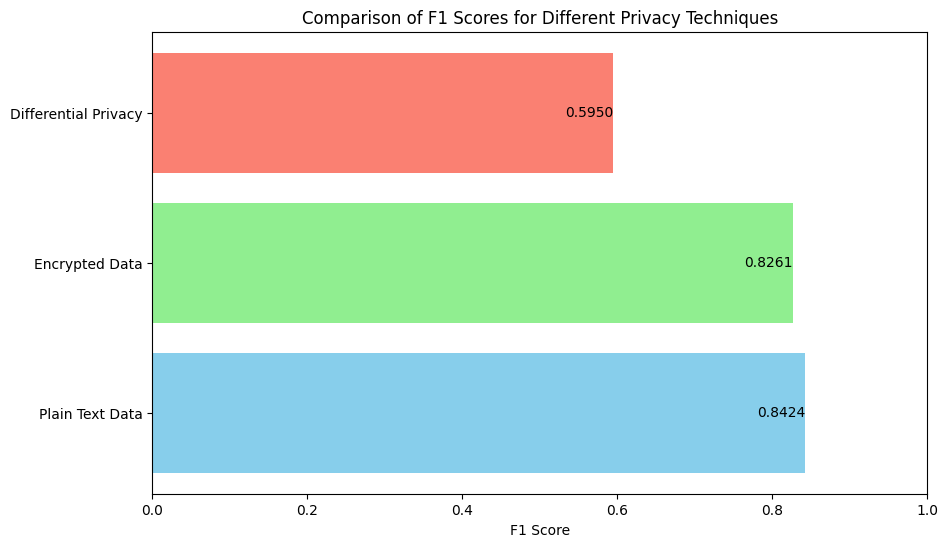

Dropdown(description='Privacy Technique:', options=('Homomorphic Encryption', 'Differential Privacy'), value='…

Output()

In [95]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np

# Updated plotting function with actual F1 scores
def plot_performance_graph():
    methods = ['Plain Text Data', 'Encrypted Data', 'Differential Privacy']
    performance = [0.8424107142857142, 0.8261068005476951, 0.5949957591178965]  # Actual F1 scores

    plt.figure(figsize=(10, 6))
    bars = plt.barh(methods, performance, color=['skyblue', 'lightgreen', 'salmon'])

    # Adding data labels
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                 f'{bar.get_width():.4f}',
                 va='center', ha='right', color='black')

    plt.xlabel('F1 Score')
    plt.title('Comparison of F1 Scores for Different Privacy Techniques')
    plt.xlim(0, 1)
    plt.show()

# Immediately display the performance graph
plot_performance_graph()

# Dropdown for privacy technique choice
dropdown_privacy_technique = widgets.Dropdown(
    options=['Plain Text Data', 'Encrypted Data', 'Differential Privacy'],
    value='Plain Text Data',
    description='Privacy Technique:',
    disabled=False,
)

output = widgets.Output()

# Function to show the chosen method
def show_chosen_method(b):
    with output:
        clear_output()
        print(f"You have chosen: {dropdown_privacy_technique.value}")

# Function to apply privacy-preserving techniques based on the sensitivity score
def apply_privacy_techniques(df, chosen_method):
    for column in df.columns:
        if column.endswith('_Type'):
            data_column = column.replace('_Type', '')
            for index, row in df.iterrows():
                data_type = row[column]
                if data_type == 'IP Address' and data_sensitivity_scores[data_type] <= 10:
                    # Apply group anonymization for IP Address
                    df.at[index, data_column] = 'ANONYMIZED'
                elif data_type == 'Email Address' and data_sensitivity_scores[data_type] <= 10:
                    # Apply group anonymization for Email Address
                    df.at[index, data_column] = 'ANONYMIZED'
                elif data_type == 'Biometric':
                    if chosen_method == 'Homomorphic Encryption':
                        df.at[index, data_column] = 'ENCRYPTED'
                    elif chosen_method == 'Differential Privacy':
                        df.at[index, data_column] = 'PROTECTED'
    return df

# Function to handle the selection change
def apply_techniques_on_selection_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        # Apply the privacy techniques based on the chosen method
        protected_df = apply_privacy_techniques(df.copy(), change['new'])  # Use a copy to preserve the original df
        with output:
            clear_output()
            display(protected_df)  # Display the modified DataFrame

# Dropdown for privacy technique choice
dropdown_privacy_technique = widgets.Dropdown(
    options=['Homomorphic Encryption', 'Differential Privacy'],
    value='Homomorphic Encryption',
    description='Privacy Technique:',
    disabled=False,
)

# Output area for displaying DataFrame
output = widgets.Output()

# Bind the dropdown change to apply techniques
dropdown_privacy_technique.observe(apply_techniques_on_selection_change, names='value')

# Display the UI components
display(dropdown_privacy_technique, output)

# Conclusion

Of course, this is a simplification of the Trefoil model for tagible demostration of integration in production. This notebook serves as a PoC to illustrate the practical application of the framework in a DevOps context. The demo code was developed using a dummy populated version of the NSL-KDD dataset. It's important to note that this implementation is primarily for demonstration purposes and should not be considered a fully operational solution. A comprehensive and effective application of the Trefoil framework requires a deep understanding of the processed data, with particular attention to its sensitivity and the appropriate privacy-preserving techniques. The nature of the data dictates the choice of techniques, such as group anonymization, cryptography, or differential privacy, underscoring the necessity of tailored implementation based on the specific data characteristics.
